#  Iterate Destination Hosts and associated Ports, over time periods, to create an Analytical Data Set &nbsp;&nbsp; for the In-Degree Entropy model

In [1]:
# use print only as a function
from __future__ import print_function
import sys
sys.version

'2.7.9 (default, Jun 29 2016, 13:08:31) \n[GCC 4.9.2]'

## Connect to data and read into dataframe

In [2]:
__author__ = 'swe03'

import numpy as np
import pandas as pd
import pandas.io.gbq as pdg
import matplotlib.pylab as plt
import matplotlib.pyplot as pplt
from decimal import *
import re 

import statsmodels.tsa as tsa

from statsmodels.tsa.stattools import ccf 
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.base import datetools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA

from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.stats.stats import pearsonr

from sklearn import linear_model

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from scipy import stats

from datetime import datetime, timedelta

desired_width = 250
pd.set_option('display.width',desired_width)
pd.set_option('display.max_rows', 500)

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


###### Install the SQL package if not already installed 

In [3]:
#!pip install pandasql

In [4]:
from pandasql import PandaSQL 
pdsql = PandaSQL()

##### Use an existing table but change the timestamps to create a contiguous distribution.

In [5]:
def Get_recs_w_date_range(date_s,date_e, addr):
    """Iterate through various date ranges to create the a timeframe sample for later aggregation"""
    global dfx2   # Otherwise, dfx2 is considered Local and will not be global scope of the dataframe created above
    query = """SELECT Timestamp, src_addr, src_port, dst_addr, dst_port,
                 cast(duration_ms as integer) as duration_ms,
                 cast(bytes as integer) as bytes,
                 protocol, flow_direction, tcp_flags 
               FROM ipfix.ipfix                
               WHERE Timestamp BETWEEN timestamp('{}') AND timestamp('{}')
                 AND dst_addr in ({})                  # single quotes unnecessary since the ip's are quoted in string 
               LIMIT 50 """.format(date_s,date_e,addr)
               
    #print('The value of local var date_s is: {}'.format(date_s))
    #print('The value of local var date_e is: {}'.format(date_e))
    print('The value of local var addr is: {}'.format(addr))
    dfx1 = pd.read_gbq(query, project_id="network-sec-analytics")
    dfx2 = dfx2.append(dfx1)                                       # Append onto the dfx2 dataframe
    return           

In [6]:
def Get_recs_w_date_range_lowgrain(date_s,date_e):
    """Iterate through various date ranges to create the a timeframe sample for later aggregation"""
    global dfx2   # Otherwise, dfx2 is considered Local and will not be global scope of the dataframe created above
    query = """SELECT Timestamp, src_addr, src_port, dst_addr, dst_port,
                 cast(duration_ms as integer) as duration_ms,
                 cast(bytes as integer) as bytes,
                 protocol, flow_direction, tcp_flags 
               FROM ipfix.ipfix                
               WHERE Timestamp BETWEEN timestamp('{}') AND timestamp('{}')
                 AND dst_addr in ('165.130.217.229') 
                 AND dst_port in ('443')
                 AND src_addr in ('172.29.236.82')""".format(date_s,date_e)
               
    #print('The value of local var date_s is: {}'.format(date_s))
    #print('The value of local var date_e is: {}'.format(date_e))
    #print('The value of local var addr is: {}'.format(addr))
    dfx1 = pd.read_gbq(query, project_id="network-sec-analytics")
    dfx2 = dfx2.append(dfx1)                                       # Append onto the dfx2 dataframe
    return       

In [7]:
def Write_to_gbq(addr_port_s):
  #model_addr_port = "'" + 'prod.' + addr_port_s + "'"
  model_addr_port = 'prod.' + addr_port_s  
  parm_str = pd.Series([model_addr_port]) 
  print("This is the parm str:",parm_str)
  
  pdg.to_gbq(dfx2, model_addr_port, "network-sec-analytics", verbose=True, reauth=False, 
   if_exists='replace', private_key=None)

  #dfx2.to_gbq(parm_str, "network-sec-analytics", verbose=True, reauth=False, 
   #if_exists='replace', private_key=None)
  return

In [8]:
def Initialize_and_Iterate():
  date_start = pd.to_datetime('2017-02-06 00:00:00')           # '2017-02-01 00:00:00'
  date_end_interval   = pd.to_datetime('2017-02-10 23:59:59')  # '2017-02-03 23:59:59'
  
  while date_start <= pd.to_datetime(date_end_interval):
    date_end = date_start + timedelta(minutes=59,seconds=59)   # Set the datetime end of the hour interval
    print('For get_recs function date_start=',date_start)
    print('For get_recs function date_end=',date_end)
    
    Get_recs_w_date_range(date_start,date_end,out_str) # Extract the query Limit above within the specified hour  
    
    date_start = date_end + timedelta(seconds=1)           # Add a second to the nn:59:59 end date to start the next # hour on nn:00:00 start time
  
  return      

In [9]:
def Initialize_and_Iterate_lowgrain():
  date_start = pd.to_datetime('2017-02-01 00:00:00')           # '2017-02-01 00:00:00'
  date_end_interval   = pd.to_datetime('2017-02-01 01:00:00')  # '2017-02-01 10:59:59'
  
  while date_start <= pd.to_datetime(date_end_interval):
    date_end = date_start + timedelta(minutes=59,seconds=59)   # Set the datetime end of the hour interval
    print('For get_recs function date_start=',date_start)
    print('For get_recs function date_end=',date_end)
    
    Get_recs_w_date_range_lowgrain(date_start,date_end) # Extract the query Limit above within the specified hour  
    
    date_start = date_end + timedelta(seconds=1)            
                                                            
  return      

In [10]:
def Create_date_hour():
  global dfx2
  dfx2['duration_ms'].fillna(0, inplace=True)
  dfx2['date_hour'] = dfx2.Timestamp.dt.strftime('%Y-%m-%d-%H')  # This works and creates a Series with Date and Hour
  dfx2['date_hour'] = pd.to_datetime(dfx2['date_hour'] )
  dfx2.reset_index(drop=True, inplace=True)
  return 

### Initiate the Process

##### Read the specific Host Segments reference table from BQ

In [11]:
## This function accomplishes both: 1. Creating an enumerated list of Host Segments to be sent to the Get_recs... function and
##                                  2. Parsing the text strings to enable generating the enumerated list
def read_in_host_segments():
  global out
  host_segs = pd.read_gbq("select Host_Range_Start, Host_Range_End from reference.Host_Segments", project_id="network-sec-analytics")
  host_start = host_segs.Host_Range_Start.str.split('.',expand=True).astype(int)  # This creates a DF.  type(host_start)
  host_end = host_segs.Host_Range_End.str.split('.',expand=True).astype(int)  # This creates a DF.  type(host_end)
  host_start2 = host_segs.join(host_start[3])   # Join the host_seg table with just the last component of the address as int
  host_start2 = host_start2.join(host_end[3],rsuffix='E') # Join to get the host range end value
  host_start2.rename(columns={"3":"start","3E":"end"},inplace=True) 
  host_start2.replace(to_replace='\w+$', value=' ', inplace=True, limit=None, regex=True, method='pad', axis=None) # place a blank in the last addr component
  
  temp_list = []
  end_str = ''
  for index, row in host_start2.iterrows(): 
    counter = host_start2['start'][index]  # necessary to include index or will get "truth value of a Series is ambiguous"
    last = host_start2['end'][index]
  while counter <= last:
    end_str = counter.astype(str)   ## counter retains int dtype
    temp_dict = {'host': row.Host_Range_Start.strip() + end_str}
    temp_list.append(temp_dict)
    counter = counter + 1
    
  out = pd.DataFrame(temp_list)   ## Currently, this will overwrite each df and only retain the last record's df

  return


read_in_host_segments()

Requesting query... ok.
Query running...
Query done.
Processed: 98.0 B

Retrieving results...
Got 3 rows.

Total time taken 0.88 s.
Finished at 2017-06-26 16:41:09.


In [12]:
##out

In [13]:
out_array=out['host'].values
#out_array
for i in range(0, len(out_array)):
  if i == 0:
    out_str = "'" + out_array[i] + "'" + ","
  else:
    if i == (len(out_array)-1):
      out_str += "'" + out_array[i] + "'" 
    else:
      out_str += "'" + out_array[i] + "',"

In [14]:
#print(out_str)
#out_str = out_str + ',' + '165.130.1.9'
print(out_str)

'165.130.217.225','165.130.217.226','165.130.217.227','165.130.217.228','165.130.217.229','165.130.217.230','165.130.217.231','165.130.217.232','165.130.217.233','165.130.217.234','165.130.217.235','165.130.217.236','165.130.217.237','165.130.217.238'


##### Call the functions

In [15]:
#global i 
#n = 2
#del dfx2
#for i in range(0, n):                # Set n to be the n number of addr/port ads's to create
dfx2 = pd.DataFrame()              # Create the df that will be appended to for each timeframe
Initialize_and_Iterate()           # For each Host/Port, iterate through the timeframes 
Create_date_hour()                 # Create a Day/Hour variable for the final, appended df
  #del dfx2                           # df has been written to BQ so now delete it

For get_recs function date_start= 2017-02-06 00:00:00
For get_recs function date_end= 2017-02-06 00:59:59
The value of local var addr is: '165.130.217.225','165.130.217.226','165.130.217.227','165.130.217.228','165.130.217.229','165.130.217.230','165.130.217.231','165.130.217.232','165.130.217.233','165.130.217.234','165.130.217.235','165.130.217.236','165.130.217.237','165.130.217.238'
Requesting query... ok.
Query running...
Query done.
Processed: 70.2 GB

Retrieving results...
Got 11 rows.

Total time taken 1.93 s.
Finished at 2017-06-26 16:41:12.
For get_recs function date_start= 2017-02-06 01:00:00
For get_recs function date_end= 2017-02-06 01:59:59
The value of local var addr is: '165.130.217.225','165.130.217.226','165.130.217.227','165.130.217.228','165.130.217.229','165.130.217.230','165.130.217.231','165.130.217.232','165.130.217.233','165.130.217.234','165.130.217.235','165.130.217.236','165.130.217.237','165.130.217.238'
Requesting query... ok.
Query running...
Query done.


In [16]:
#dfx2 = pd.DataFrame()              # Create the df that will be appended to for each timeframe
#Initialize_and_Iterate_lowgrain()           # For each Host/Port, iterate through the timeframes 
#Create_date_hour()                 # Create a Day/Hour variable for the final, appended df

In [17]:
dfx_s=dfx2.sort_values(['date_hour','dst_addr'],ascending=True)
dfx_s

,Timestamp,src_addr,src_port,dst_addr,dst_port,duration_ms,bytes,protocol,flow_direction,tcp_flags,date_hour
2,2017-02-06 00:48:45,172.29.237.82,41576,165.130.217.229,443,12,2546,tcp,None,[FS.PA...],2017-02-06 00:00:00
3,2017-02-06 00:22:45,172.29.237.82,61209,165.130.217.229,443,13,2546,tcp,None,[FS.PA...],2017-02-06 00:00:00
6,2017-02-06 00:47:27,172.29.236.82,16268,165.130.217.229,443,3,817,tcp,None,[FS.PA...],2017-02-06 00:00:00
1,2017-02-06 00:30:33,172.29.236.82,31022,165.130.217.230,443,7,1001,tcp,None,[FS.PA...],2017-02-06 00:00:00
4,2017-02-06 00:10:48,172.29.236.82,56962,165.130.217.230,443,12,1273,tcp,None,[FS.PA...],2017-02-06 00:00:00
10,2017-02-06 00:34:48,172.29.236.82,9198,165.130.217.230,443,3,777,tcp,None,[FS.PA...],2017-02-06 00:00:00
0,2017-02-06 00:52:59,172.29.236.82,57478,165.130.217.231,443,6,1001,tcp,None,[FS.PA...],2017-02-06 00:00:00
5,2017-02-06 00:45:35,172.29.237.82,54727,165.130.217.231,443,37837,720,tcp,None,[..R.A...],2017-02-06 00:00:00
7,2017-02-06 00:03:10,172.29.237.82,49464,165.130.217.231,443,14,2546,tcp,None,[FS.PA...],2017-02-06 00:00:00
8,2017-02-06 00:04:25,172.29.237.82,32311,165.130.217.231,443,3,1634,tcp,None,[FS.PA...],2017-02-06 00:00:00


### Create the Behaviorial Metrics (i.e., In-Degree Entropy measures)

In [40]:
## New
host_count=dfx_s.groupby(['date_hour']).dst_addr.nunique()    ## This creates a Series
host_count

date_hour
2017-02-06 00:00:00    4
2017-02-06 01:00:00    2
2017-02-06 02:00:00    4
2017-02-06 03:00:00    4
2017-02-06 04:00:00    3
2017-02-06 05:00:00    4
2017-02-06 06:00:00    2
2017-02-06 07:00:00    4
2017-02-06 08:00:00    3
2017-02-06 09:00:00    4
2017-02-06 10:00:00    3
2017-02-06 11:00:00    3
2017-02-06 12:00:00    3
2017-02-06 13:00:00    3
2017-02-06 14:00:00    4
2017-02-06 15:00:00    4
2017-02-06 16:00:00    4
2017-02-06 17:00:00    4
2017-02-06 18:00:00    4
2017-02-06 19:00:00    3
2017-02-06 20:00:00    4
2017-02-06 21:00:00    3
2017-02-06 22:00:00    3
2017-02-06 23:00:00    3
2017-02-07 00:00:00    4
2017-02-07 01:00:00    3
2017-02-07 02:00:00    3
2017-02-07 03:00:00    4
2017-02-07 04:00:00    3
2017-02-07 05:00:00    2
2017-02-07 06:00:00    3
2017-02-07 07:00:00    5
2017-02-07 08:00:00    3
2017-02-07 09:00:00    4
2017-02-07 10:00:00    5
2017-02-07 11:00:00    4
2017-02-07 12:00:00    4
2017-02-07 13:00:00    4
2017-02-07 14:00:00    4
2017-02-07 15:0

In [39]:
## Old
#host_count = dfx_s.groupby(dfx_s['date_hour']).count()   ## This creates a dataframe
#host_count['dst_addr'] = pd.to_numeric(host_count['dst_addr'],downcast='float')   ## another way to conver is below
#host_count['dst_addr']

In [41]:
## New
host_count_df = pdsql("""Select * from host_count""", locals())   ## host_count is a Series
#type(unq_src_count_df)                                                    ## test for a Dataframe
host_count_df['dst_addr'] = host_count_df.dst_addr.astype(float)
host_count_df                                             ## Dataframe has cols:  date_hour, dst_addr, and src_addr (which are the unique counts)

,date_hour,dst_addr
0,2017-02-06 00:00:00.000000,4.0
1,2017-02-06 01:00:00.000000,2.0
2,2017-02-06 02:00:00.000000,4.0
3,2017-02-06 03:00:00.000000,4.0
4,2017-02-06 04:00:00.000000,3.0
5,2017-02-06 05:00:00.000000,4.0
6,2017-02-06 06:00:00.000000,2.0
7,2017-02-06 07:00:00.000000,4.0
8,2017-02-06 08:00:00.000000,3.0
9,2017-02-06 09:00:00.000000,4.0


In [42]:
unq_src_count=dfx_s.groupby(['date_hour','dst_addr']).src_addr.nunique()    ## This creates a Series
unq_src_count

date_hour            dst_addr       
2017-02-06 00:00:00  165.130.217.229    2
                     165.130.217.230    1
                     165.130.217.231    2
                     165.130.217.235    1
2017-02-06 01:00:00  165.130.217.229    1
                     165.130.217.230    1
2017-02-06 02:00:00  165.130.217.228    1
                     165.130.217.229    2
                     165.130.217.230    1
                     165.130.217.231    2
2017-02-06 03:00:00  165.130.217.228    1
                     165.130.217.229    2
                     165.130.217.230    1
                     165.130.217.231    1
2017-02-06 04:00:00  165.130.217.229    1
                     165.130.217.230    1
                     165.130.217.231    1
2017-02-06 05:00:00  165.130.217.229    2
                     165.130.217.230    2
                     165.130.217.231    2
                     165.130.217.235    1
2017-02-06 06:00:00  165.130.217.229    2
                     165.130.217.231   

In [22]:
#type(unq_src_count)

In [43]:
## Old
#unq_src_count_df = pdsql("""Select * from unq_src_count""", locals())   ## unq_src_count is a Series
##type(unq_src_count_df)                                                    ## test is a Dataframe
#unq_src_count_df['src_addr'] = unq_src_count_df.src_addr.astype(float)
#unq_src_count_df                                             ## Dataframe has cols:  date_hour, dst_addr, 
                                                                          ## and src_addr (which are the unique counts)

In [44]:
## New
calc_ent1 = pdsql("""SELECT s.date_hour, s.src_addr as unq_src_addr_cnt, count(src_addr) as xi_cnt 
                  from unq_src_count_df s
                  group by s.date_hour, s.src_addr
                  order by s.date_hour""",locals())
calc_ent1

,date_hour,unq_src_addr_cnt,xi_cnt
0,2017-02-06 00:00:00.000000,1.0,2
1,2017-02-06 00:00:00.000000,2.0,2
2,2017-02-06 01:00:00.000000,1.0,2
3,2017-02-06 02:00:00.000000,1.0,2
4,2017-02-06 02:00:00.000000,2.0,2
5,2017-02-06 03:00:00.000000,1.0,3
6,2017-02-06 03:00:00.000000,2.0,1
7,2017-02-06 04:00:00.000000,1.0,3
8,2017-02-06 05:00:00.000000,1.0,1
9,2017-02-06 05:00:00.000000,2.0,3


In [28]:
## Old
#calc_ent1 = pdsql("""SELECT s.date_hour, s.dst_addr as dst_addr_s, s.src_addr as unq_src_addr_cnt, 
#                            i.dst_addr as total_dst_addr_cnt, (s.src_addr / i.dst_addr) as ent1 
#                  from host_count_df i join unq_src_count_df s
#                  on  i.date_hour = s.date_hour 
#                  order by s.date_hour""",locals())
#calc_ent1

In [45]:
## New
calc_ent2 = pdsql("""SELECT s.date_hour, s.xi_cnt, i.dst_addr, s.unq_src_addr_cnt, 
                     (s.xi_cnt / i.dst_addr) as ent1 
                  from host_count_df i join calc_ent1 s
                  on  i.date_hour = s.date_hour 
                  order by s.date_hour""",locals())
calc_ent2

,date_hour,xi_cnt,dst_addr,unq_src_addr_cnt,ent1
0,2017-02-06 00:00:00.000000,2,4.0,1.0,0.500000
1,2017-02-06 00:00:00.000000,2,4.0,2.0,0.500000
2,2017-02-06 01:00:00.000000,2,2.0,1.0,1.000000
3,2017-02-06 02:00:00.000000,2,4.0,1.0,0.500000
4,2017-02-06 02:00:00.000000,2,4.0,2.0,0.500000
5,2017-02-06 03:00:00.000000,3,4.0,1.0,0.750000
6,2017-02-06 03:00:00.000000,1,4.0,2.0,0.250000
7,2017-02-06 04:00:00.000000,3,3.0,1.0,1.000000
8,2017-02-06 05:00:00.000000,1,4.0,1.0,0.250000
9,2017-02-06 05:00:00.000000,3,4.0,2.0,0.750000


In [ ]:
## Old
#calc_ent1['ln_ent1'] = np.log(calc_ent1['ent1'])
#calc_ent1

In [46]:
## New
calc_ent2['ln_ent1'] = np.log(calc_ent2['ent1'])     ### Natural Log 
calc_ent2

,date_hour,xi_cnt,dst_addr,unq_src_addr_cnt,ent1,ln_ent1
0,2017-02-06 00:00:00.000000,2,4.0,1.0,0.500000,-0.693147
1,2017-02-06 00:00:00.000000,2,4.0,2.0,0.500000,-0.693147
2,2017-02-06 01:00:00.000000,2,2.0,1.0,1.000000,0.000000
3,2017-02-06 02:00:00.000000,2,4.0,1.0,0.500000,-0.693147
4,2017-02-06 02:00:00.000000,2,4.0,2.0,0.500000,-0.693147
5,2017-02-06 03:00:00.000000,3,4.0,1.0,0.750000,-0.287682
6,2017-02-06 03:00:00.000000,1,4.0,2.0,0.250000,-1.386294
7,2017-02-06 04:00:00.000000,3,3.0,1.0,1.000000,0.000000
8,2017-02-06 05:00:00.000000,1,4.0,1.0,0.250000,-1.386294
9,2017-02-06 05:00:00.000000,3,4.0,2.0,0.750000,-0.287682


In [32]:
## Old
## This is the step where the summation of each entt1(first ratio created above) * log of ent1 is calculated.
## This summation is now reflected in the date_hour group by
#calc_ent1['dst_addr_datehour_group'] = calc_ent1['dst_addr_s']    ## Create a new variable for better desc
#calc_ent1['dst_addr_datehour_group'] = calc_ent1.date_hour.str.slice(start=0,stop=13,step=None) #substr the dt/hour only
#calc_ent2 = pdsql("""SELECT i.date_hour, i.dst_addr_datehour_group, i.total_dst_addr_cnt, i.ent1, i.ln_ent1,
#                     sum(i.ent1 * i.ln_ent1) as hx_ent, count(dst_addr_s) as unq_dst_host_count,
#                     sum(i.unq_src_addr_cnt) as unq_src_dst_addr_cnt
#                  from calc_ent1 i
#                  group by i.date_hour
#                  order by i.date_hour""",locals())

#calc_ent2

In [47]:
## New
#calc_ent1['dst_addr_datehour_group'] = calc_ent1['dst_addr_s']    ## Create a new variable for better desc
calc_ent2['dst_addr_datehour_group'] = calc_ent1.date_hour.str.slice(start=0,stop=13,step=None) #substr the dt/hour only
calc_ent3 = pdsql("""SELECT i.date_hour, i.dst_addr_datehour_group, count(i.xi_cnt) as xi_cnt, i.dst_addr, i.unq_src_addr_cnt, i.ent1, i.ln_ent1,
                     sum(i.ent1 * i.ln_ent1) as hx_ent, count(i.date_hour) as unq_dst_host_count
                  from calc_ent2 i
                  group by i.date_hour
                  order by i.date_hour""",locals())

calc_ent3

,date_hour,dst_addr_datehour_group,xi_cnt,dst_addr,unq_src_addr_cnt,ent1,ln_ent1,hx_ent,unq_dst_host_count
0,2017-02-06 00:00:00.000000,2017-02-06 00,2,4.0,2.0,0.500000,-0.693147,-0.693147,2
1,2017-02-06 01:00:00.000000,2017-02-06 01,1,2.0,1.0,1.000000,0.000000,0.000000,1
2,2017-02-06 02:00:00.000000,2017-02-06 02,2,4.0,2.0,0.500000,-0.693147,-0.693147,2
3,2017-02-06 03:00:00.000000,2017-02-06 03,2,4.0,2.0,0.250000,-1.386294,-0.562335,2
4,2017-02-06 04:00:00.000000,2017-02-06 04,1,3.0,1.0,1.000000,0.000000,0.000000,1
5,2017-02-06 05:00:00.000000,2017-02-06 05,2,4.0,2.0,0.750000,-0.287682,-0.562335,2
6,2017-02-06 06:00:00.000000,2017-02-06 06,1,2.0,2.0,1.000000,0.000000,0.000000,1
7,2017-02-06 07:00:00.000000,2017-02-06 07,2,4.0,2.0,0.750000,-0.287682,-0.562335,2
8,2017-02-06 08:00:00.000000,2017-02-06 08,1,3.0,2.0,1.000000,0.000000,0.000000,1
9,2017-02-06 09:00:00.000000,2017-02-06 09,2,4.0,2.0,0.250000,-1.386294,-0.562335,2


In [52]:
calc_ent3['In_degree_entropy'] = -(calc_ent3['hx_ent'] / np.log(calc_ent3['unq_dst_host_count']))  ## Natural Log 
calc_ent3.fillna(value=0, inplace=True)

In [27]:
##### Write the dataframe to BQ
#dfx2.to_gbq('prod.host_group2', "network-sec-analytics", verbose=True, reauth=False, 
#   if_exists='replace', private_key=None)




Streaming Insert is 100% Complete




#### Create some visualizations and other stats

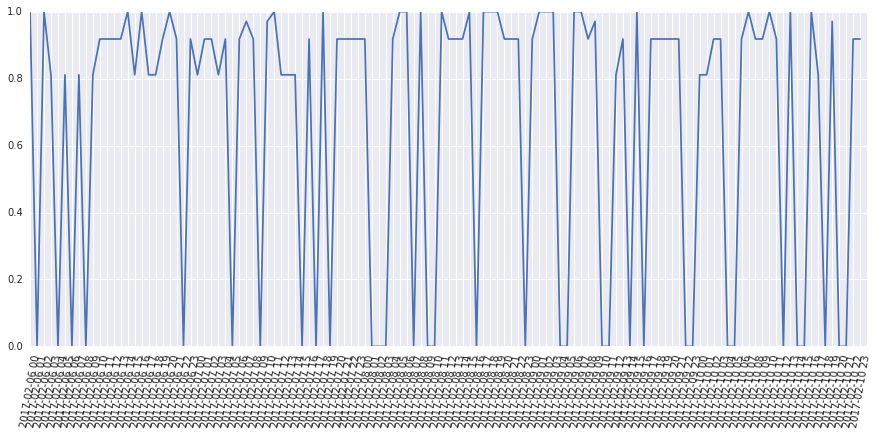

In [53]:
import matplotlib.pyplot as pplt
pplt.plot(calc_ent3['In_degree_entropy'])
pplt.xticks(range(len(calc_ent3['dst_addr_datehour_group'])),calc_ent3['dst_addr_datehour_group'])
pplt.xticks(rotation=80)
#pplt.autoscale(enable=True, axis='x', tight=None)
pplt.show()

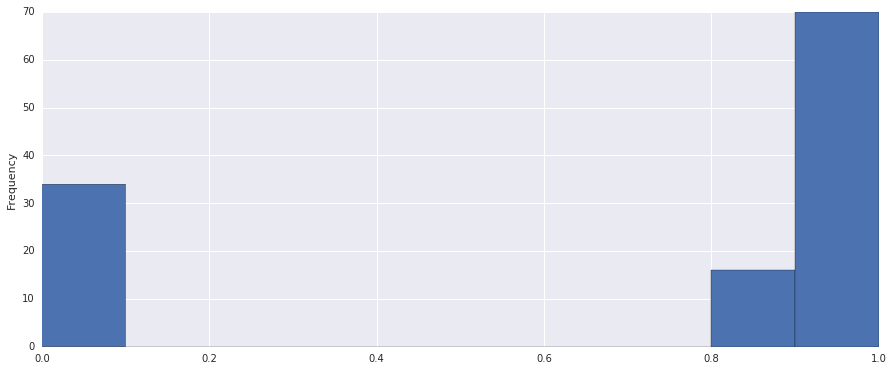

In [54]:
hist_plot = calc_ent3['In_degree_entropy'].plot.hist()

In [56]:
##### Run a correlation to see the relationship between calc_ents indicator features
##### All correlations are statistically significant 
corr1 = pearsonr(calc_ent3['dst_addr'],calc_ent3['unq_src_addr_cnt'])
corr2 = pearsonr(calc_ent3['dst_addr'],calc_ent3['In_degree_entropy'])
corr3 = pearsonr(calc_ent3['unq_src_addr_cnt'],calc_ent3['In_degree_entropy'])
print("feature correlation = ",corr1)
print("dst_addr_cnt x Entropy = ", corr2)
print("unq_src_addr_cnt x Entropy = ", corr3)

feature correlation =  (0.29406050716815685, 0.0011143448718963082)
dst_addr_cnt x Entropy =  (0.35815309882951812, 5.9099272399508499e-05)
unq_src_addr_cnt x Entropy =  (0.78846290330778757, 1.1487989791575519e-26)


In [64]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Create the various feature arrays (1,5,6 for x and 7 for y)
x1 = calc_ent3[['dst_addr']]
x2 = calc_ent3['unq_dst_host_count'] * calc_ent3['dst_addr']
x2 = x2.values.reshape(-1,1)
x3 = calc_ent3['unq_src_addr_cnt'] * calc_ent3['dst_addr']
x3 = x3.values.reshape(-1,1)
y = calc_ent3['In_degree_entropy']

In [66]:
x3

array([[  8.],
       [  2.],
       [  8.],
       [  8.],
       [  3.],
       [  8.],
       [  4.],
       [  8.],
       [  6.],
       [  8.],
       [  6.],
       [  6.],
       [  6.],
       [  6.],
       [  8.],
       [  8.],
       [  8.],
       [  8.],
       [  8.],
       [  6.],
       [  8.],
       [  6.],
       [  3.],
       [  6.],
       [  8.],
       [  6.],
       [  6.],
       [  8.],
       [  6.],
       [  4.],
       [  6.],
       [ 10.],
       [  6.],
       [  4.],
       [ 10.],
       [  8.],
       [  8.],
       [  8.],
       [  8.],
       [  6.],
       [  6.],
       [  6.],
       [  8.],
       [  3.],
       [  6.],
       [  6.],
       [  6.],
       [  6.],
       [  6.],
       [  3.],
       [  2.],
       [  2.],
       [  6.],
       [  4.],
       [  4.],
       [  2.],
       [  4.],
       [  3.],
       [  2.],
       [  4.],
       [  6.],
       [  6.],
       [  6.],
       [  4.],
       [  3.],
       [  4.],
       [  

Coefficients: 
 [ 0.18001878]
Mean squared error: 0.15
Variance score: 0.13


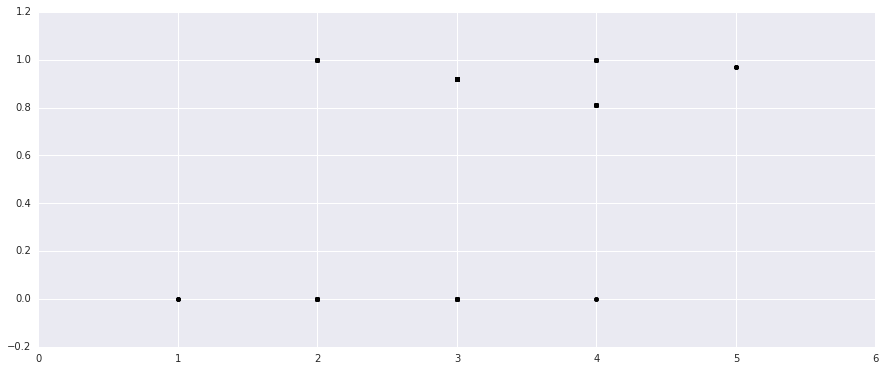

Coefficients: 
 [ 0.1410023]
Mean squared error: 0.07
Variance score: 0.58


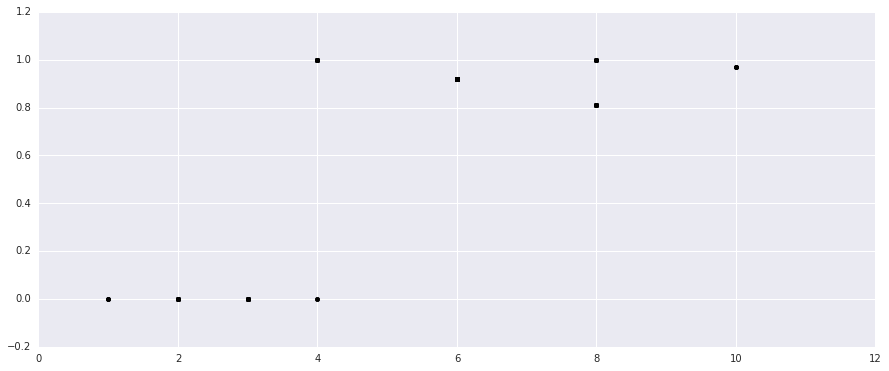

Coefficients: 
 [ 0.13135427]
Mean squared error: 0.10
Variance score: 0.44


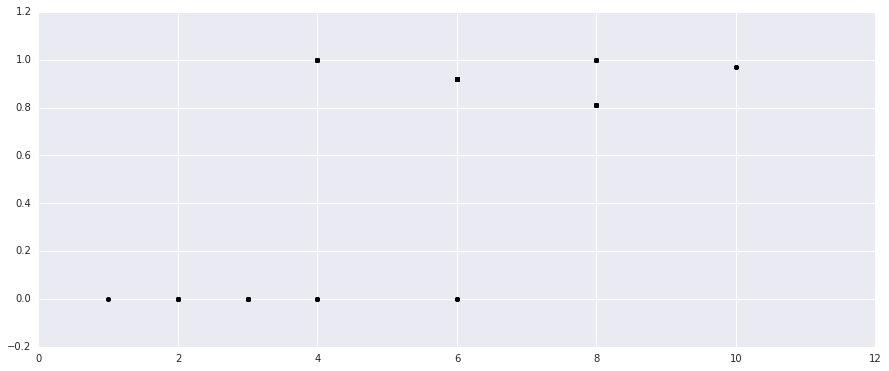

In [67]:
# Fit the Regression Model using the arrays created above
def regression_plots(feature_array):
  regr.fit(feature_array, y)

  # The coefficients
  print('Coefficients: \n', regr.coef_)
  # The mean squared error
  print("Mean squared error: %.2f"
      % np.mean((regr.predict(feature_array) - y) ** 2))
  # Explained variance score: 1 is perfect prediction
  print('Variance score: %.2f' % regr.score(feature_array, y))

  # Plot outputs
  plt.scatter(feature_array, y,  color='black')
  #plt.plot(x1, regr.predict(feature_array), color='blue',
  #       linewidth=3)


  plt.show()
  
regression_plots(x1)
regression_plots(x2)
regression_plots(x3)

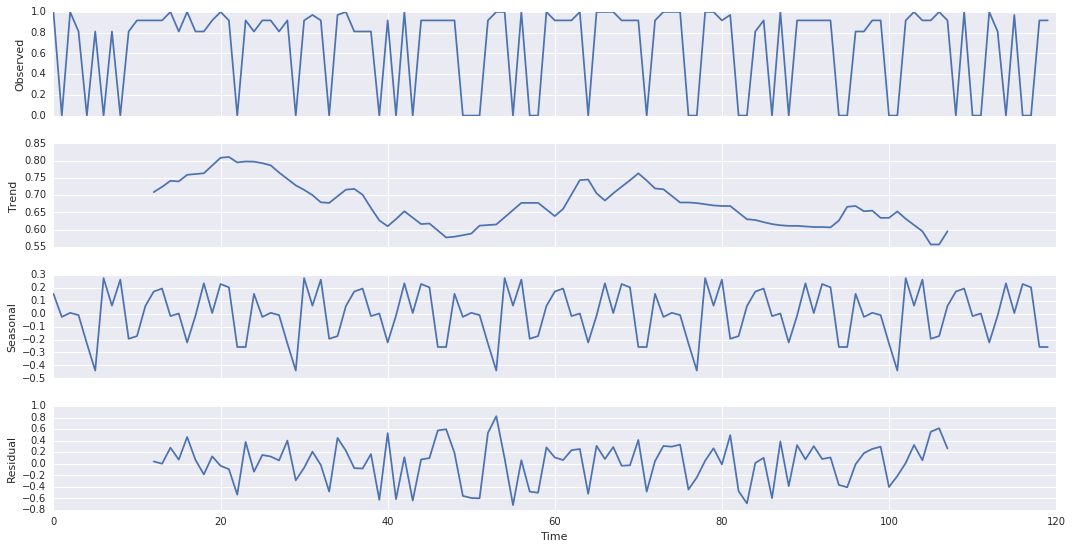

In [68]:
decomposition = seasonal_decompose(calc_ent3.In_degree_entropy.values, freq=24)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [69]:
calc_ent3.index = calc_ent3['date_hour']
type(calc_ent2['date_hour'])

pandas.core.series.Series

In [70]:
model=ARIMA(calc_ent3['In_degree_entropy'],(1,0,0))    ## The endogenous variable needs to be type Float or you get a cast error
model_fit = model.fit()       # fit is a Function
model_fitted = model_fit.fittedvalues    # fittedvalues is a Series
print(model_fit.summary())
print(model_fitted)

                              ARMA Model Results                              
Dep. Variable:      In_degree_entropy   No. Observations:                  120
Model:                     ARMA(1, 0)   Log Likelihood                 -66.145
Method:                       css-mle   S.D. of innovations              0.420
Date:                Mon, 26 Jun 2017   AIC                            138.291
Time:                        17:55:07   BIC                            146.653
Sample:                    02-06-2017   HQIC                           141.687
                         - 02-10-2017                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.6624      0.037     17.920      0.000       0.590       0.735
ar.L1.In_degree_entropy    -0.0373      0.091     -0.409      0.684      -0.216       0.142


In [ ]:
def create_unistats(group):
    return {'min': group.min(), 'max': group.max(), 'count': group.count(), 'mean': group.mean()}
  
# These are DataFrames
bytes_dist = dfx2['bytes'].groupby([dfx2['date_hour'],   
                                  dfx2['dst_port']]).apply(create_unistats).unstack().reset_index()
bytes_dist = bytes_dist[(bytes_dist['dst_port']==53) ]   # all stats are displayed for just port 53

duration_dist = dfx2['duration_ms'].groupby([dfx2['date_hour'],   
                                  dfx2['dst_port']]).apply(create_unistats).unstack().reset_index()